## Read data

In [86]:
import pandas as pd
import numpy as np

df = pd.read_csv('spotify-songs-preprocessed.csv')

df.head()

,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,album_songs,popular,genre_pop,genre_rap,genre_dance pop,genre_hip hop,genre_pop rap,genre_rock,genre_r&b
0,71,0.853,0.606,0.0,66.0,1.0,0.0713,0.0561,0.000000,0.313,...,227600.0,2,True,1,1,0,0,1,0,0
1,69,0.514,0.911,1.0,30.0,0.0,0.4100,0.0559,0.000000,0.775,...,254027.0,3,False,1,0,1,0,0,0,1
2,88,0.780,0.768,6.0,63.0,0.0,0.2380,0.0371,0.000002,0.518,...,404107.0,1,True,0,1,0,1,0,0,0
3,71,0.766,0.563,9.0,87.0,0.0,0.0339,0.0263,0.683000,0.115,...,230640.0,2,True,1,0,1,0,0,0,0
4,75,0.754,0.811,5.0,56.0,1.0,0.0561,0.0185,0.000005,0.654,...,267960.0,1,False,1,0,1,0,0,0,0


In [87]:
print ("Records and variables: ", df.shape)

Records and variables:  (2199, 22)


## Split data into train and test set

In [88]:
from sklearn.model_selection import train_test_split

y = df.pop('popular') # Target column
x = df

#split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=100,
    stratify=y
)

In [89]:
print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Train:  (1649, 21) (1649,)
Test:  (550, 21) (550,)


## Train the base model

In [90]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

params = {
    'objective': 'binary:logistic',  
    'learning_rate': 0.1,
    'max_depth': 5,
    'alpha': 10,
    'colsample_bytree': 0.3,
    'eval_metric': 'auc'  
}

xg_clf = xgb.XGBClassifier(**params)

In [91]:
xg_clf.fit(x_train, y_train)
preds = xg_clf.predict(x_test)
preds2 = xg_clf.predict(x_train)

In [92]:
acc1 = accuracy_score(y_test, preds)
acc2 = accuracy_score(y_train, preds2)

print("Attempt 1 Train accuracy: %f" % (acc2))
print("Attmept 1 Test accuracy: %f" % (acc1))

Attempt 1 Train accuracy: 0.790782
Attmept 1 Test accuracy: 0.758182


## Train using GridSearchCV

In [93]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Some inputs do not have OOB scores",
    category=UserWarning,
    module="sklearn.ensemble._forest"
)

In [94]:
data_dmatrix = xgb.DMatrix(data=x, label=y)

In [95]:
cv_results = xgb.cv(
    dtrain=data_dmatrix,
    params=params,
    nfold=5,
    num_boost_round=50,
    early_stopping_rounds=10,
    metrics='auc',     
    as_pandas=True,
    seed=123
)

# and review results (latest iterations)
cv_results.tail()

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
45,0.838053,0.004054,0.755226,0.013702
46,0.839326,0.004295,0.754594,0.013708
47,0.841164,0.003955,0.754689,0.013441
48,0.841976,0.003885,0.754664,0.013335
49,0.843156,0.004156,0.754183,0.013247


In [96]:
gbm_param_grid = {
    'objective': ['binary:logistic'],
    'learning_rate': [0.2, 0.1, 0.3, 1],
    'n_estimators': [50, 5, 10],
    'max_depth': [5, 10, 15],
    'colsample_bytree': [0.7, 0.5, 1],
    'subsample': [0.6, 0.7, 0.65]  # subsample is % of rows per tree
}

In [97]:
import time 
start_time = time.time()

from sklearn.model_selection import GridSearchCV
gbm = xgb.XGBClassifier()
grid_roc = GridSearchCV(
    estimator=gbm,
    param_grid=gbm_param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=1,
)

grid_roc.fit(x, y)

print ("Completed in %s seconds" % (time.time() - start_time))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/Users/luisguareschi/Documents/IEMaster/machine-learning-2/group-project-ml-2/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Completed in 7.469538927078247 seconds


In [98]:
grid_roc.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.2,
 'max_depth': 5,
 'n_estimators': 10,
 'objective': 'binary:logistic',
 'subsample': 0.6}

In [99]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
grid_roc.best_score_

np.float64(0.7203972080867032)

In [100]:
train_acc = round(grid_roc.score(x_train, y_train) * 100,2) #Train Accuracy score
test_acc = round(grid_roc.score(x_test, y_test) * 100,2) #Test Accuracy score
print("Train Accuracy score: ", train_acc, "%")
print("Test Accuracy score: ", test_acc, "%")

Train Accuracy score:  86.42 %
Test Accuracy score:  89.34 %


## Compare the performance of the best model with the base model

In [101]:
initial_acc = acc1
improved_acc = test_acc/100
improvement = round((improved_acc - initial_acc) / initial_acc * 100, 2)
print("Initial Accuracy: ", round(initial_acc, 2)*100, "%")
print("Improved Accuracy: ", round(improved_acc, 2)*100, "% \u2713")
print("Improvement: ", round(improvement, 2), "%")


Initial Accuracy:  76.0 %
Improved Accuracy:  89.0 % ✓
Improvement:  17.83 %


## Final Model performance

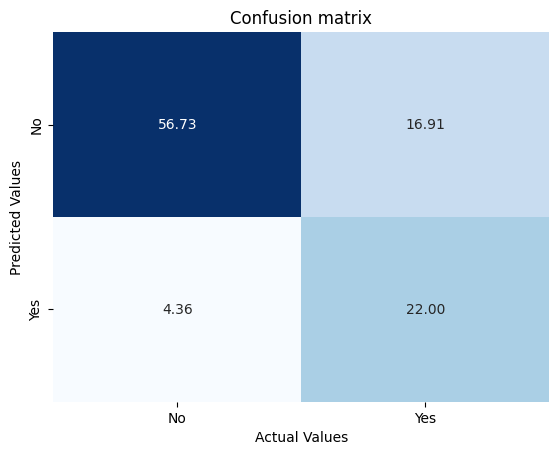

In [102]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cutoff = 0.27

model = grid_roc

prob_pred = model.predict_proba(x_test)[:, 1]
predictions_test = (prob_pred >= cutoff).astype(int)

test_conf_matrix = confusion_matrix(y_test, predictions_test)
test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2) 
labels = ['No', 'Yes']

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in test_conf_matrix_percentage.flatten()]

# Draw heatmap using confusion matrix
import seaborn as sns
sns.heatmap(test_conf_matrix_percentage, annot=True, fmt='.2f', cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)

ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values');

Optimal Threshold: 0.27


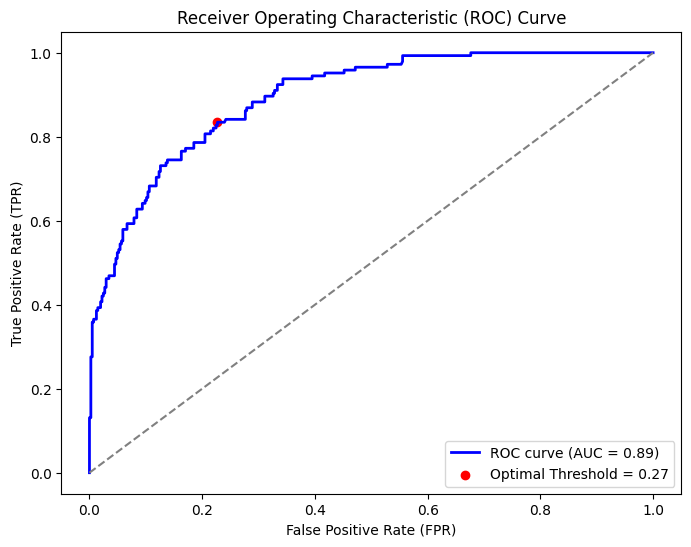

In [103]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)  
optimal_idx = np.argmax(tpr - fpr)  # Best trade-off between TPR and FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classification

# Highlight optimal threshold 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Create a function to use the model to predict the popularity of a new song

In [104]:
def predict_popularity(model: xgb.XGBClassifier, song_features: dict) -> int:
    """
    Predicts the popularity of a new song based on its features.
    
    Args:
        model: Trained XGBoost model
        song_features: Dictionary containing song features
        
    Returns:
        Predicted popularity score (0 or 1)
    """

    required_features = df.columns.tolist()
    if not all(feature in song_features for feature in required_features):
        raise ValueError(f"Missing required features: {set(required_features) - set(song_features.keys())}")

    # Convert song_features to a DataFrame
    song_features_df = pd.DataFrame([song_features])
    
    # Make prediction
    prediction = model.predict_proba(song_features_df)[:, 1]

    return prediction[0]

#### Test the function

In [105]:
song_features = {
    'artist_popularity': 100,
    'danceability': 0.99,
    'energy': 0.99,
    'key': 0.0,
    'loudness': 66.0,
    'mode': 1.0,
    'speechiness': 0.0713,
    'acousticness': 0.0561,
    'instrumentalness': 0.0,
    'liveness': 0.813,
    'valence': 0.654,
    'tempo': 120.0,
    'duration_ms': 227600.0,
    'album_songs': 10,
    'genre_pop': 1,
    'genre_rap': 0,
    'genre_dance pop': 1,
    'genre_hip hop': 1,
    'genre_pop rap': 1,
    'genre_rock': 0,
    'genre_r&b': 1
}

result = predict_popularity(model=model, song_features=song_features)
print(f"Predicted popularity score: {result:.2f}")

Predicted popularity score: 0.62
